# How climate change perceptions vary around the world?

In [34]:
# Import libraries
import config
import pandas as pd
import numpy as np
import itertools
import collections

import tweepy
from textblob import TextBlob
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import networkx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /home/ivana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Interacting with twitter's API
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret) 
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API (auth, wait_on_rate_limit = True) 

In [6]:
# Clean the tweets
def clean_tweet(tweet):
    """ Utility function to clean a tweet by removing 
    links and special characters using regex.

    Parameters
    ----------
    tweet : string
        A text string that you want to parse and remove special characters.

    Returns
    -------
    The same tweet string without special characters removed.
    """
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())   

In [21]:
# List of tweets related to climate change
search_words = ("#ClimateChange", "Environment", "climate", "climatechange", "environment")


def get_tweets_df(search_words):
    """Extracts tweets, finds sentiment score and returns tweets as a DataFrame 

    Parameters
    ----------
    search_words : list 
        A list of phrases to extract
    
    Returns
    -------
    Pandas DataFrame of tweets
    """
    res = []
    # Extract tweets for a given list of phrases
    for word in search_words:
        for tweet in tweepy.Cursor (api.search, 
                                    q = word + " -filter:retweets", 
                                    lang = "en").items(30):
            res.append(tweet)
   
    id_list = [tweet.id for tweet  in res]
    
    # Create tweets DataFrame
    data_set = pd.DataFrame(id_list, columns = ["id"])
    data_set["text"] = [tweet.text for tweet in res]
    data_set["len"]  = np.array([len(tweet.text) for tweet in res])
    data_set["created_at"] = [tweet.created_at for tweet in res]
    data_set["user_location"] = [tweet.author.location for tweet in res]
    data_set["Hashtags"] = [tweet.entities.get('hashtags') for tweet in res]
    
    # Use clean function to remove special characters
    data_set["text"] = np.array([ clean_tweet(tweet) for tweet in data_set['text'] ])
    
    # Add Sentiment score and class
    text = data_set["text"]
    for i in range(0,len(text)):
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity

        data_set.at[i, 'sentiment'] = sentiment
        if sentiment <0.00:
            SentimentClass = 'Negative'
            data_set.at[i, 'sentiment_class'] = SentimentClass 
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            data_set.at[i, 'sentiment_class']= SentimentClass 
        else:
            SentimentClass = 'Neutral'
            data_set.at[i, 'sentiment_class']= SentimentClass
    
    return data_set
    

In [22]:
# Create tweets DataFrame
tweets_df = get_tweets_df(search_words)
tweets_df.head()

,id,text,len,created_at,user_location,Hashtags,sentiment,sentiment_class
0,1177198055847845888,Climatechange affects oceans species at twice ...,111,2019-09-26 12:27:42,"Bonn, Germany","[{'text': 'Climatechange', 'indices': [0, 14]}]",0.00,Neutral
1,1177198009463033856,Today on Party Lines The polls suggest that mo...,140,2019-09-26 12:27:31,Canada,"[{'text': 'climatechange', 'indices': [75, 89]}]",0.45,Positive
2,1177198004488552448,I support the bipartisan Nuclear Energy Leader...,140,2019-09-26 12:27:30,"Wauwatosa, WI","[{'text': 'NELA', 'indices': [56, 61]}, {'text...",0.05,Positive
3,1177198001103822848,Like ClimateChange need to ask an expert not a...,139,2019-09-26 12:27:29,,"[{'text': 'ClimateChange', 'indices': [15, 29]...",0.10,Positive
4,1177197986495041538,There was almost no temperature difference fro...,140,2019-09-26 12:27:25,,[],1.00,Positive


### Text clean up
To preprocess the tweets we will need to replace capital letters with lower case, remove stopwords and transform words to their base form.


In [23]:
# Create a list of lists containing lowercase words for each tweet
lower_tweets = [tweet.lower().split() for tweet in tweets_df.text] 
lower_tweets[:2]

[['climatechange',
  'affects',
  'oceans',
  'species',
  'at',
  'twice',
  'the',
  'rate',
  'that',
  'is',
  'affecting',
  'land',
  'species'],
 ['today',
  'on',
  'party',
  'lines',
  'the',
  'polls',
  'suggest',
  'that',
  'most',
  'canadians',
  'see',
  'addressing',
  'climatechange',
  'as',
  'important',
  'or',
  'urgent']]

In [24]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in lower_tweets]
tweets_nsw[:2]

[['climatechange',
  'affects',
  'oceans',
  'species',
  'twice',
  'rate',
  'affecting',
  'land',
  'species'],
 ['today',
  'party',
  'lines',
  'polls',
  'suggest',
  'canadians',
  'see',
  'addressing',
  'climatechange',
  'important',
  'urgent']]

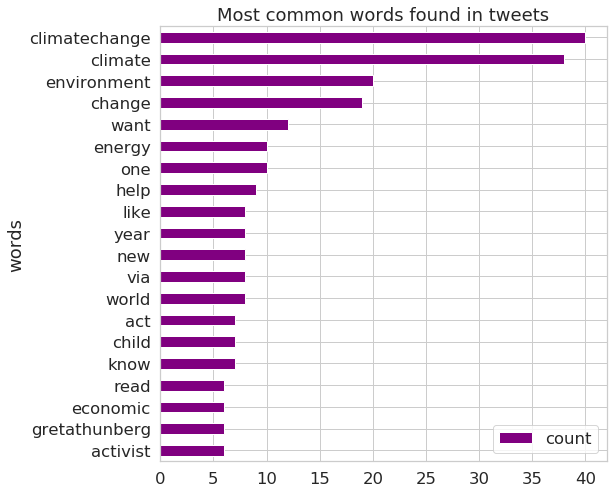

In [30]:
# Flatten list of words in clean tweets
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets")
plt.show()

In addition to removal of stopwords, we will also create a collection of our own topic related words. Since we have  used "climated change" as a collection term, this term appear in every collected tweet. Therefore, we can expect that these terms will dominate the list of the most frequent words. In order to obtain new insight into the perceptions of twitter users we remove the search words from tweets through list comprehension.

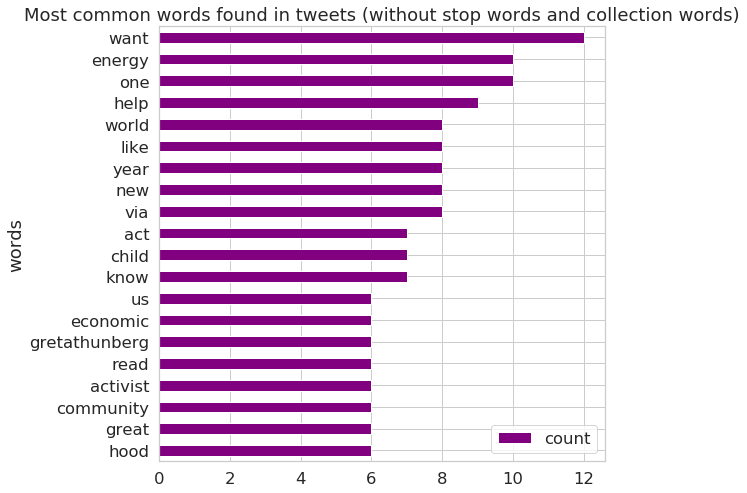

In [31]:
# Create a list of words to remove
remove_words = ("#ClimateChange", "Environment", "climate", "climatechange", "change", "amp", "much", "environment")

# Remove search words and rerun word frequency plot
tweets_nsw_rsw = [[w for w in word if not w in remove_words]
                  for word in tweets_nsw]

# Flatten list of words in clean tweets
all_words_nsw_rsw = list(itertools.chain(*tweets_nsw_rsw))

# Create a counter of top 20 terms
words_count = collections.Counter(all_words_nsw_rsw)
clean_tweets_nsw = pd.DataFrame(words_count.most_common(20), columns=['words', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common words found in tweets (without stop words and collection words)")
plt.show()

In next section I will explore the co-occuring words (bigrams) in the tweets. Analysis of bigrams provides deeper understanding compared to single words.

In [36]:
# Create a list of lists containing bigrams in tweets
tweet_bigrams = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_rsw]

# Display bigrams from the first tweet
tweet_bigrams[0]

[('affects', 'oceans'),
 ('oceans', 'species'),
 ('species', 'twice'),
 ('twice', 'rate'),
 ('rate', 'affecting'),
 ('affecting', 'land'),
 ('land', 'species')]

In [42]:
# Display the original tweet 
tweets_df.text[0]

'Climatechange affects oceans species at twice the rate that is affecting land species'

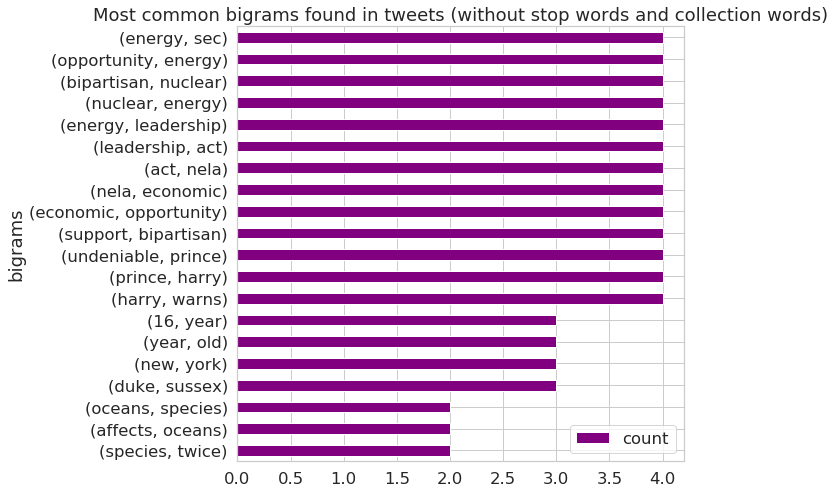

In [43]:
# Flatten list of bigrams
bigrams = list(itertools.chain(*tweet_bigrams))

# Create a counter of most frequent bigrams
bigrams_count = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigrams_count.most_common(20),
                         columns=['bigrams', 'count'])

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 8))
bigram_df.sort_values(by='count').plot.barh(x='bigrams',
                                                  y='count',
                                                  ax=ax,
                                                  color='purple')
ax.set_title("Most common bigrams found in tweets (without stop words and collection words)")
plt.show()

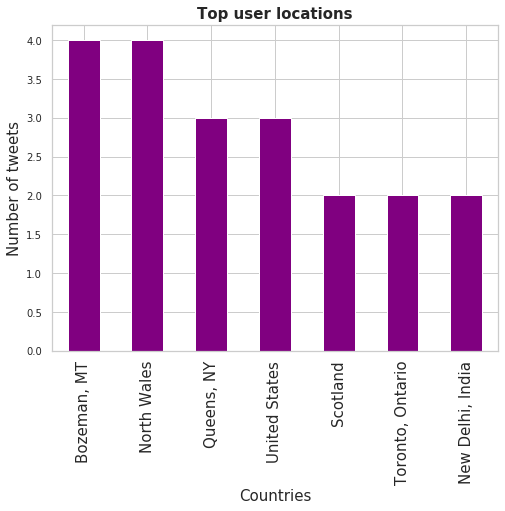

In [32]:
# Plot horizontal bar graph to see where majority of tweets are from
tweets_by_country = tweets_df['user_location'].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top user locations',fontsize=15, fontweight='bold')
tweets_by_country[1:8].plot(ax=ax, kind='bar', color='purple')